In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import numpy as np

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
    def forward(self, z):
        return self.model(z).view(-1,1,28,28)

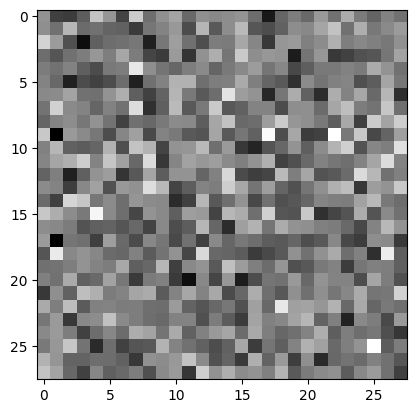

In [4]:
G = Generator()

input_z = torch.randn(1,100)

fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.LeakyReLU(0.2),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

In [6]:
D = Discriminator()

input_z = torch.randn(1,100)
fake_images = G(input_z)

d_out = D(fake_images)

# 출력 d_out에 Sigmoid를 곱해 0에서 1로 변환
print(nn.Sigmoid()(d_out))

tensor([[0.6244]], grad_fn=<SigmoidBackward0>)


In [7]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST',
                    train=True,
                    download=True,
                    transform=transforms.Compose([
                        transforms.Resize(28),
                        transforms.ToTensor(),
                        transforms.Normalize([0.5],[0.5])
                    ])),
    batch_size=64, shuffle=True
)

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
    def forward(self, z):
        return self.model(z).view(-1,1,28,28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator().to(device)
D = Discriminator().to(device)

opt_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()

num_epochs = 100

# 평가를 위해 고정된 노이즈 벡터 생성(이미지 생성 비교용)
fixed_noise = torch.randn(64,100, device=device)

os.makedirs('./content/images', exist_ok=True)
os.makedirs('./content/results', exist_ok=True)

In [12]:
for epoch in range(num_epochs):
    G.train()
    D.train()

    total_d_loss = 0.0
    total_g_loss = 0.0
    total_real_score = 0.0
    total_fake_score = 0.0
    num_batches = 0

    for real_images, _ in dataloader:
        num_batches += 1
        batch_size = real_images.size(0)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        #판별자 학습
        D.zero_grad()
        # real image
        outputs_real = D(real_images.to(device))
        d_loss_real = criterion(outputs_real, real_labels)
        real_score = outputs_real.mean().item()

        # fake image
        noise = torch.randn(batch_size, 100, device=device)
        fake_images = G(noise)
        outputs_fake = D(fake_images.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)
        fake_score = outputs_fake.mean().item()

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        opt_D.step()

        # 생성기 학습
        G.zero_grad()
        noise2 = torch.randn(batch_size, 100, device=device)
        fake_images2 = G(noise2)
        outputs = D(fake_images2)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        opt_G.step()

        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        total_real_score += real_score
        total_fake_score += fake_score

    avg_d_loss = total_d_loss / num_batches
    avg_g_loss = total_g_loss / num_batches
    avg_real_score = total_real_score / num_batches
    avg_fake_score = total_fake_score / num_batches
    
    print(f'Epoch {epoch+1}/{num_epochs} : d_loss={avg_d_loss:.4f}, g_loss={g_loss:.4f}, '
          f'D(X)={avg_real_score:.2f}, D(G(z)={avg_fake_score:.2f}')
    
    G.eval()
    D.eval()
    with torch.no_grad():
        fake_image = G(fixed_noise)
        save_image(fake_image, f'./content/images/fake_image_ep_{epoch+1:04d}.png', normalize=True)
        discriminator_outputs = D(fake_image).cpu().detach().numpy().reshape(8,8)
        np.save(f'./content/results/discriminator_outputs_ep_{epoch+1:04d}.npy', discriminator_outputs) 

Epoch 1/100 : d_loss=0.7121, g_loss=1.0672, D(X)=0.77, D(G(z)=0.23
Epoch 2/100 : d_loss=0.7289, g_loss=1.2600, D(X)=0.77, D(G(z)=0.23
Epoch 3/100 : d_loss=0.7743, g_loss=1.8116, D(X)=0.75, D(G(z)=0.25
Epoch 4/100 : d_loss=0.7875, g_loss=2.5385, D(X)=0.75, D(G(z)=0.26
Epoch 5/100 : d_loss=0.8271, g_loss=1.3170, D(X)=0.73, D(G(z)=0.27
Epoch 6/100 : d_loss=0.8456, g_loss=1.7571, D(X)=0.73, D(G(z)=0.28
Epoch 7/100 : d_loss=0.8431, g_loss=1.6381, D(X)=0.73, D(G(z)=0.28
Epoch 8/100 : d_loss=0.8539, g_loss=1.5300, D(X)=0.72, D(G(z)=0.28
Epoch 9/100 : d_loss=0.8541, g_loss=1.8717, D(X)=0.72, D(G(z)=0.28
Epoch 10/100 : d_loss=0.8647, g_loss=1.3287, D(X)=0.72, D(G(z)=0.29
Epoch 11/100 : d_loss=0.8716, g_loss=1.6581, D(X)=0.71, D(G(z)=0.29
Epoch 12/100 : d_loss=0.8739, g_loss=2.0051, D(X)=0.71, D(G(z)=0.29
Epoch 13/100 : d_loss=0.8814, g_loss=1.7663, D(X)=0.71, D(G(z)=0.29
Epoch 14/100 : d_loss=0.8883, g_loss=1.2536, D(X)=0.71, D(G(z)=0.29
Epoch 15/100 : d_loss=0.8852, g_loss=1.4172, D(X)=0.71, D